In [38]:
### Auxiliary Functions
import matplotlib.pyplot as plt

def line_chart(ax: plt.Axes, xvalues: list, yvalues: list, title: str, xlabel: str, ylabel: str, percentage=False):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    ax.plot(xvalues, yvalues)

def multiple_line_chart(ax: plt.Axes, xvalues: list, yvalues: dict, title: str, xlabel: str, ylabel: str, percentage=False):
    legend: list = []
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    for name, y in yvalues.items():
        ax.plot(xvalues, y)
        legend.append(name)
    ax.legend(legend, loc='best', fancybox = True, shadow = True)   
    
def plot_roc_chart(ax: plt.Axes, models: dict, tstX, tstY, target: str='class'):
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('FP rate')
    ax.set_ylabel('TP rate')
    ax.set_title('ROC chart for %s'%target)
    ax.plot([0, 1], [0, 1], color='navy', label='random', linestyle='--')    
    for clf in models:
        scores = models[clf].predict_proba(tstX)[:,1]
        fpr, tpr, _ = metrics.roc_curve(tstY, scores, 'positive')
        roc_auc = metrics.roc_auc_score(tstY, scores)
        ax.plot(fpr, tpr, label='%s (auc=%0.2f)' %(clf, roc_auc))
    ax.legend(loc="lower center")



# Description

##### The goal of this project is to apply data science techniques to discover information in two distinct datasets. The second dataset predicts forest cover type from cartographic variables only. It includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold

data = pd.read_csv('covtype.csv', sep=',')

data.shape

(581012, 55)

In [40]:
data.head(5)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [41]:
data.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [42]:
cat_vars = data.select_dtypes(include='category')
cat_vars.columns.size

0

In [43]:
num_vars = data.select_dtypes(include='number')
num_vars.columns.size

55

In [44]:
null_vars = {}
for var in data:
    nas = data[var].isna().sum()
    if nas > 0:
        null_vars[var] = nas
print(len(null_vars))

0


##### The dataset has half a million records and 55 attributes, all numeric, and does not have any null values, just like the first dataset

### Reducing Sample Size

In [45]:
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type'].values

In [53]:
print("X", X.shape)
print("y", y.shape)

X (581012, 54)
y (581012,)


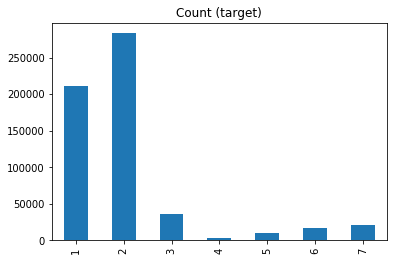

In [46]:
y_series = pd.Series(y)
target_count = y_series.value_counts().sort_index()
target_count.plot(kind='bar', title='Count (target)');

In [52]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

sampler = RandomUnderSampler(random_state=12)
X_res, y_res = sampler.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 2747, 2: 2747, 3: 2747, 4: 2747, 5: 2747, 6: 2747, 7: 2747})


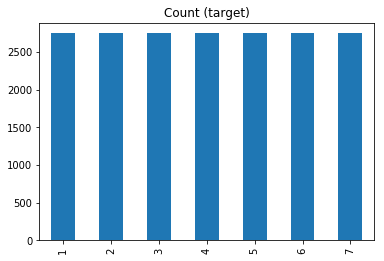

In [48]:
y_res_series = pd.Series(y_res)
target_count_res = y_res_series.value_counts().sort_index()
target_count_res.plot(kind='bar', title='Count (target)');

# Classification

##### For the PD dataset, the target variable is 'Cover_Type' with a range from 1 to 7.

### Training Strategy

In [63]:
# Hold-Out 
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size=0.3, 
                                                    random_state=13, 
                                                    stratify=y_res)

### KNN

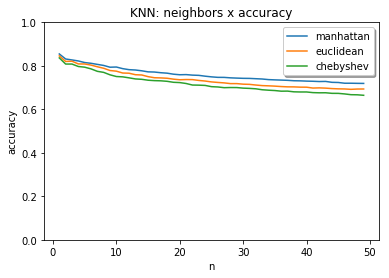

In [64]:
n_neighbors = range(1,50)
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
for d in dist:
    accuracy_values = []
    for n in n_neighbors:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(X_train, y_train)
        y_predict = knn.predict(X_test)
        accuracy_values.append(metrics.accuracy_score(y_test, y_predict))
    values[d] = accuracy_values
plt.figure()
multiple_line_chart(plt.gca(), n_neighbors, values, 'KNN: neighbors x accuracy', 'n', 'accuracy', percentage=True)
plt.show()